# Urban Sound Classification, Part 2
## Data Preprocessing and CNN configuration

Author: David Salvo Gutiérrez

### Introduction
In this chapter we preprocess dataset from feature extraction, defining training and test dataset. Then we create our CNN to classify urban sound into 10 classes, defined at turtorial part 1.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
# print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import pandas as pd
import librosa
from datetime import datetime 

from sklearn import model_selection
from sklearn.model_selection import train_test_split 

import numpy as np

print(tf.__version__)

2.3.0


In [3]:
def get_stream(audio, window_size): # fix the audio data size up to 3s (512*128frames=65536)
    
    if audio.shape[0] < window_size:
        padding = np.zeros(window_size-audio.shape[0])
        stream = np.concatenate((audio,padding), axis=0)
#         print('shape menor', stream.shape)
    elif audio.shape[0] >= window_size:
        stream = np.resize(audio,window_size)
#         print('shape mayor', stream.shape)
        
    return stream

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

# to extract log-scaled mel-sèctrpgrams with 128 bands covering audible freq (0-22.050Hz)
# using windows_size of 23 ms (1024 samples at 44.1 kHz) and a hop size of the same duration
# fix the input TF-patch X to 3s (128 frames)
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 128, frames = 128):
    window_stream = 512 * (frames - 1) # fix all audio input up to 3 seconds
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
# Cambiar codigo de forma que se obtenga el valor de la etiqueta
# desde el archivo .csv "metadata" y no desde el nombre de archivo
        for fn in glob.glob(os.path.join(os.path.abspath(parent_dir),sub_dir,file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('-')[3]
            stream = get_stream(sound_clip,window_stream)

            # revisar el atributo win_length=n_fft/2=1024 de los 2048 de n_fft
            melspec = librosa.feature.melspectrogram(stream, sr=s, win_length=512, n_mels = bands) #revisar n_mels a 128
            logspec = librosa.power_to_db(melspec, ref=np.max)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [5]:
# Loading Features and Label arrays
features = np.load('../../train_dataset/features_no10.npy')
labels = np.load('../../train_dataset/labels_no10.npy')

In [6]:
print(features.shape)
print(labels.shape)

(7796, 128, 128, 2)
(7796,)


In [7]:
# Split the data set into training and test
validation_size = 0.20
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(features, labels, test_size=validation_size, random_state=seed)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(type(X_train))

(6236, 128, 128, 2)
(1560, 128, 128, 2)
<class 'numpy.ndarray'>


## Create a model using Keras

The TensorFlow tf.keras API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The tf.keras.Sequential model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two Dense layers with 10 nodes each, and an output layer with 10 nodes representing our label predictions. The first layer's input_shape parameter corresponds to the number of features from the dataset, and is required:

Input shape

4D tensor with shape: (batch, channels, rows, cols) if data_format is "channels_first" or 4D tensor with shape: (batch, rows, cols, channels) if data_format is "channels_last".

### Convolutional Neural Network (CNN) model architecture
We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend.

Again we will use a sequential model, starting with a simple model architecture, consisting of four Conv2D convolution layers, with our final output layer being a dense layer.

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution.

The filter parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the kernel_size parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix.

The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono.

The activation function we will be using for our convolutional layers is ReLU which is the same as our previous model. We will use a smaller Dropout value of 20% on our convolutional layers.

Each convolutional layer has an associated pooling layer of MaxPooling2D type with the final convolutional layer having a GlobalAveragePooling2D type. The pooling layer is do reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our dense output layer.

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is softmax. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

Using TensorFlow backend.


In [3]:
# Load pre-trained model
model = tf.keras.models.load_model('models/no10_model.h5')

In [10]:
# Construct model 
model = models.Sequential()
# model2 = models.Sequential()

# model
model.add(layers.Conv2D(24, (5, 5), activation='relu', input_shape=(128, 128, 2)))
model.add(layers.MaxPooling2D((4, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(48, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((4, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(48, (5, 5), activation='relu'))

# model 2
# model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 41, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()
# model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 24)      1224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 62, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 25, 48)         5

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [11]:
# model 1
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# model 2

# model2.add(layers.Flatten())
# model2.add(layers.Dense(64, activation='relu'))
# model2.add(layers.Dense(10, activation='softmax'))


model.summary()
# model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 24)      1224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 62, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 25, 48)         5

### Compile and train the model

In [12]:
# model 1
start = datetime.now()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=25, 
                    validation_data=(X_test, Y_test))

duration = datetime.now() - start
print("Model compilation completed in time: ", duration)

Train on 6236 samples, validate on 1560 samples
Epoch 1/25
6236/6236 [==============================] - 63s 10ms/sample - loss: 2.5758 - accuracy: 0.1454 - val_loss: 2.1568 - val_accuracy: 0.1994
Epoch 2/25
6236/6236 [==============================] - 58s 9ms/sample - loss: 1.8768 - accuracy: 0.3023 - val_loss: 1.8014 - val_accuracy: 0.3705
Epoch 3/25
6236/6236 [==============================] - 56s 9ms/sample - loss: 1.4239 - accuracy: 0.4901 - val_loss: 1.4886 - val_accuracy: 0.5141
Epoch 4/25
6236/6236 [==============================] - 58s 9ms/sample - loss: 1.1390 - accuracy: 0.6113 - val_loss: 1.3789 - val_accuracy: 0.5301
Epoch 5/25
6236/6236 [==============================] - 57s 9ms/sample - loss: 0.9726 - accuracy: 0.6679 - val_loss: 0.9769 - val_accuracy: 0.6859
Epoch 6/25
6236/6236 [==============================] - 61s 10ms/sample - loss: 0.8129 - accuracy: 0.7227 - val_loss: 1.0101 - val_accuracy: 0.7006
Epoch 7/25
6236/6236 [==============================] - 57s 9ms/samp

In [10]:
# # model 2
# start = datetime.now()
# model2.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = model2.fit(X_train, Y_train, epochs=10, 
#                     validation_data=(X_test, Y_test))

# duration = datetime.now() - start
# print("Model compilation completed in time: ", duration)

### Evaluate the model

1560/1560 - 3s - loss: 0.4495 - accuracy: 0.8615


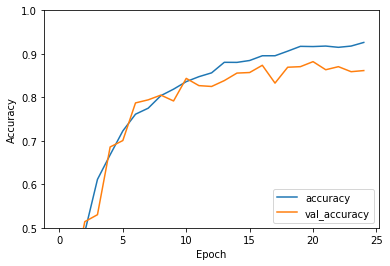

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(X_train,  Y_train, verbose=2)
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

In [14]:
train_score = model.evaluate(X_train, Y_train, verbose=0)
test_score = model.evaluate(X_test, Y_test, verbose=0)

print("Training Accuracy: ", train_score[1])
print("Testing Accuracy: ", test_score[1])

Training Accuracy:  0.9457986
Testing Accuracy:  0.86153847


In [15]:
# Guardar el modelo
model.save('models/no10_model.h5')

Our trained model obtained a Training accuracy of 94.2% and a Testing accuracy of 83.3%.

# Use the trined model to make predictions
We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on unlabeled examples; that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

In [4]:
class_names = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog Bark', 
               'Drilling', 'Engine Idling', 'Gun Shot', 
               'Jackhammer', 'Siren', 'Street Music']


In [17]:
# Loading Features and Label arrays
features_test = np.load('features_horn.npy')
labels_test = np.load('labels_.npy')

In [18]:
# print(features_test)
# print(labels_test)
# print(labels_train)

[3 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 3 3 2 2 2 2 2 2 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9
 9 9 9 9 9 5 5 5 9 9 9 9 9 9 9 9 9 9 9 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 4 4 4 4 4 4 4 4 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 3 3 3 3 9 9 9 9 9 9 3 3 3 3 9 9 9 9 9 9 3 3 3 3 6
 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 8 8 8 8 8 8 8 8 8 8 8 8 8 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 8 8 8 8 8 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 6 8 8
 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 0 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 3 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 9 9 9 9 9 9 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 2 2 2 2 2 1 3 3 3 3 4 4 

In [19]:
# test_loss, test_acc = model.evaluate(features_test, labels_test, verbose=2)
test_loss, test_acc = model.evaluate(features_test, labels_test, verbose=2)

936/936 - 2s - loss: 1.3400 - accuracy: 0.6635


In [6]:
def print_prediction(parent_dir,sub_dirs):

    features,labels = extract_features(parent_dir,sub_dirs)
    predicted_vector = model.predict_classes(features)
    print("The predicted class is:", class_names[predicted_vector[0]], '\n') 

    predicted_proba_vector = model.predict_proba(features) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        print(class_names[i], "\t\t : ", format(predicted_proba[i], '.32f') )

In [21]:
# Prediction for Dog Bark example FOLD 5
parent_dir = '../../dataset-Dani/'
sub_dirs= ['fold1']
print_prediction(parent_dir,sub_dirs)

The predicted class is: Children Playing 

Air Conditioner 		 :  0.00274633872322738170623779296875
Car Horn 		 :  0.07909527420997619628906250000000
Children Playing 		 :  0.64591860771179199218750000000000
Dog Bark 		 :  0.00884242914617061614990234375000
Drilling 		 :  0.00018605531658977270126342773438
Engine Idling 		 :  0.00271209562197327613830566406250
Gun Shot 		 :  0.00000871671545610297471284866333
Jackhammer 		 :  0.00002914110700658056885004043579
Siren 		 :  0.01807806082069873809814453125000
Street Music 		 :  0.24238343536853790283203125000000


In [19]:
# # Other Example of prediction
# prediction = model.predict_classes(features_test)
# # show the inputs and predicted outputs
# for i in range(len(features_test)):
# 	print("Predicted=%s " % (class_names[prediction[i]]) + ', Real Value=%s ' % (class_names[labels_test[i]]))

## CONFUSION MATRIX

# Tensorflow Lite Converter

In [ ]:
# Convert the model.
import tensorflow as tf
from tensorflow.keras import models

# LOAD PRE-TRAINED MODEL
model = tf.keras.models.load_model('models/no10_model.h5')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model10.tflite', 'wb') as f:
  f.write(tflite_model)